In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

M=3577297

def add_flame_data(df, t, e):
    if (e == 0):
        profile_file = f"../data/baseline_profile_rank_t_{t}.csv"
        class_name = "gk/GKbaseline"
    else :
        profile_file = f"../data/profile_t_{t}_e_{e}.csv"
        class_name = "gk/GK"
    
    df_flame = pd.read_csv(profile_file, names=["call"])
    df_flame['target'] = t
    df_flame['epsilon'] = e
    #df_flame = pd.concat(df_flame)
    df_flame["call"] = df_flame["call"].astype("string")
    df_flame["call"].replace({None: ""}, inplace=True)
    df_flame["num"] = df_flame["call"].apply(lambda x: x.split(";")[-1].split(" ")[-1])
    df_flame["num"] = pd.to_numeric(df_flame["num"], errors="coerce")
    total = df_flame[(df_flame["target"] == t) & (df_flame["epsilon"] == e) ]["num"].sum()
    df["proc_update"] = df_flame[df_flame["call"].str.contains(f"{class_name}.update")]["num"].sum()/total
    df["proc_updatePure"] = df_flame[df_flame["call"].str.contains(f"gk/GK.updatePure")]["num"].sum()/total
    df["proc_compress"] = df_flame[df_flame["call"].str.contains(f"gk/GK.compress")]["num"].sum()/total
    df["proc_javaIO"] = df_flame[df_flame["call"].str.contains("java.io")]["num"].sum()/total
    df["proc_queryRank"] = df_flame[df_flame["call"].str.contains(f"{class_name}.rank")]["num"].sum()/total
    return df


TARGETS = [0, 3, 4, 5, 6, 7]
EPS = [0.01, 0.05, 0.1]
###Baseline###
df_list = []
for t in TARGETS:
    drank = pd.read_csv(f"../data/BASELINE_RANK_T_{t}.csv", names=["rank"])
    dquery = pd.read_csv(f"../data/INPUT_query_rank_t_{t}.csv", names=["queryR"])

    df = pd.concat([drank,dquery], axis=1)
    df['target'] = t
    
    dtime = pd.read_csv("../data/baseline_gk_trace.csv")
    df = df.set_index('target').join(dtime[dtime["query"]=="rank"].set_index('target'))
    
    df['tempo_inicio'] = df['tempo_inicio'].astype('datetime64[ns]')
    df['tempo_fim'] = df['tempo_fim'].astype('datetime64[ns]')
    df['tempo_exec'] = (df['tempo_fim'] - df['tempo_inicio'])
    df.drop(['tempo_inicio', 'tempo_fim'], axis=1, inplace=True)
    df = add_flame_data(df,t,0)
    
    df_list.append(df.reset_index())
df_base = pd.concat(df_list)

###GK###
df_list = []
for t in TARGETS:
    for e in EPS:
        drank = pd.read_csv(f"../data/GK_RANK_T_{t}_E_{e}.csv", names=["rank"])
        drquery = pd.read_csv(f"../data/INPUT_query_rank_t_{t}.csv", names=["queryR"])
        
        dfr = pd.concat([drank,drquery], axis=1)
        dfr['target'] = t
        dfr['epsilon'] = e
        dfr = dfr.set_index(["target", "epsilon"])
        
        dtime = pd.read_csv("../data/gk_profile_trace.csv")
        dtime = dtime.set_index(['target', 'epsilon'])
        dfr = dfr.join(dtime[dtime["query"] == "rank"])
        
        dfr['tempo_inicio'] = dfr['tempo_inicio'].astype('datetime64[ns]')
        dfr['tempo_fim'] = dfr['tempo_fim'].astype('datetime64[ns]')
        dfr['tempo_exec'] = (dfr['tempo_fim'] - dfr['tempo_inicio'])
        dfr.drop(['tempo_inicio', 'tempo_fim'], axis=1, inplace=True)
        
        dfr = add_flame_data(dfr,t,e)
        df_list.append(dfr.reset_index())
df_gk = pd.concat(df_list)
df_base = df_base.set_index(["target", "queryR"])
df_gk = df_gk.set_index(["target", "queryR"])

#df_base["erro"] = abs(df_base["rank"] - df_base["rank"] )
#df_base["erro_max"] =  df_base["epsilon"] * M

#df_gk["erro"] = abs(df_gk["rank"] - df_gk["rank"] )
#df_gk["erro_max"] =  df_gk["epsilon"] * M

df = df_base.join(df_gk, lsuffix="_baseline")
df["erro"] = abs(df["rank_baseline"] - df["rank"] )
df["erro_max"] =  df["epsilon"] * M

df_gk = df_gk.reset_index()
df_base = df_base.reset_index()
df = df.reset_index()

len(df)

3432

In [131]:
df["tempo_exec_int"] = df["tempo_exec"].astype("int")/1000000000
df["tempo_exec_int_baseline"] = df["tempo_exec_baseline"].astype("int")/1000000000


df["tempo_update_baseline"] = df["proc_update_baseline"] * df["tempo_exec_int_baseline"]
df["tempo_query_baseline"] = df["proc_queryRank_baseline"] * df["tempo_exec_int_baseline"]
df["tempo_io_baseline"] = df["proc_javaIO_baseline"] * df["tempo_exec_int_baseline"]

df["tempo_update"] = df["proc_update"] * df["tempo_exec_int"]
df["tempo_query"] = df["proc_queryRank"] * df["tempo_exec_int"]
df["tempo_io"] = df["proc_javaIO"] * df["tempo_exec_int"]

/tmp/ipykernel_32247/2298409064.py:1: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df["tempo_exec_int"] = df["tempo_exec"].astype("int")/1000000000
/tmp/ipykernel_32247/2298409064.py:2: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df["tempo_exec_int_baseline"] = df["tempo_exec_baseline"].astype("int")/1000000000


In [132]:
#TODO tempo para montar estrutura
df_heatMap = df.drop_duplicates(subset=["epsilon", "target"])

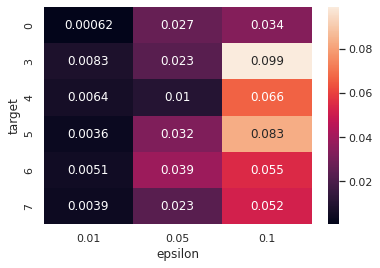

In [133]:
erro = df_heatMap.pivot("target", "epsilon", "erro")
f = sns.heatmap(erro/M, annot=True)
f.get_figure().savefig("../img/heatmap_ERRO")

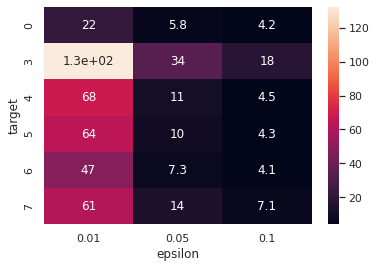

In [134]:
tempos = df_heatMap.pivot("target", "epsilon", "tempo_exec_int")
f = sns.heatmap(tempos, annot=True)
f.get_figure().savefig("../img/heatmap_TEMPO")

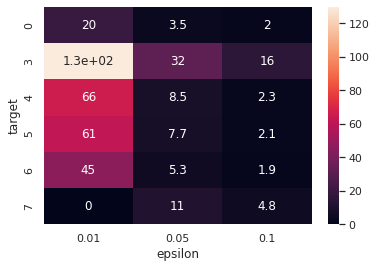

In [135]:
tempos = df_heatMap.pivot("target", "epsilon", "tempo_update")
f = sns.heatmap(tempos, annot=True)
f.get_figure().savefig("../img/heatmap_TEMPO_UPDATE")

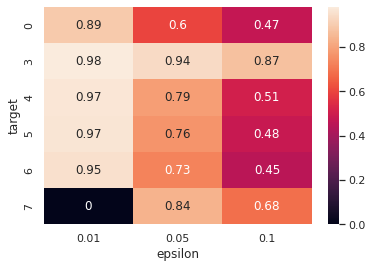

In [136]:
tempos = df_heatMap.pivot("target", "epsilon", "proc_update")
f = sns.heatmap(tempos, annot=True)
f.get_figure().savefig("../img/heatmap_PROC_UPDATE")

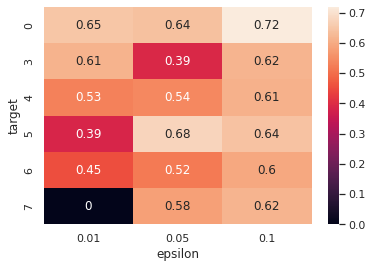

In [137]:
tempos = df_heatMap.pivot("target", "epsilon", "tempo_io")
f = sns.heatmap(tempos, annot=True)
f.get_figure().savefig("../img/heatmap_TEMPO_IO")

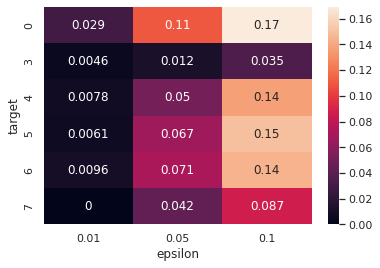

In [138]:
tempos = df_heatMap.pivot("target", "epsilon", "proc_javaIO")
f = sns.heatmap(tempos, annot=True)
f.get_figure().savefig("../img/heatmap_PROC_IO")

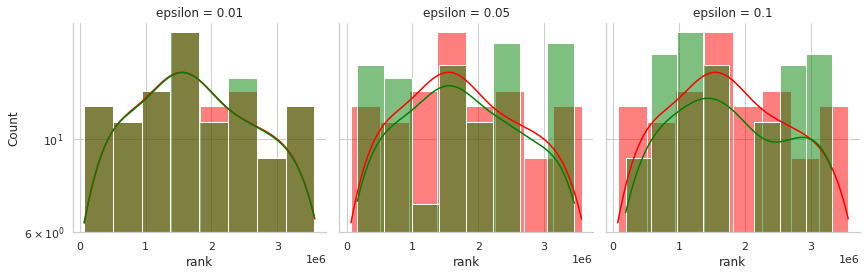

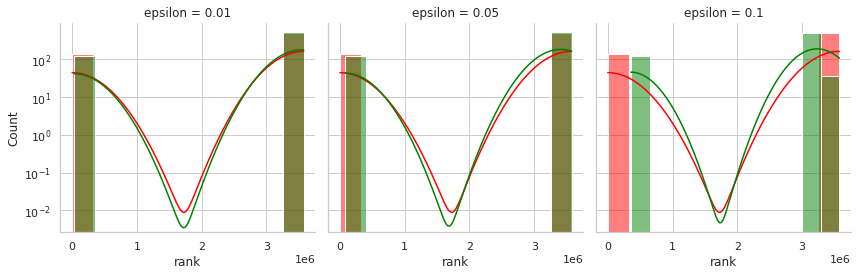

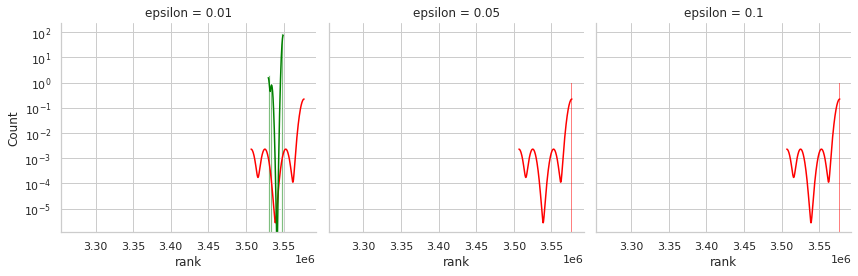

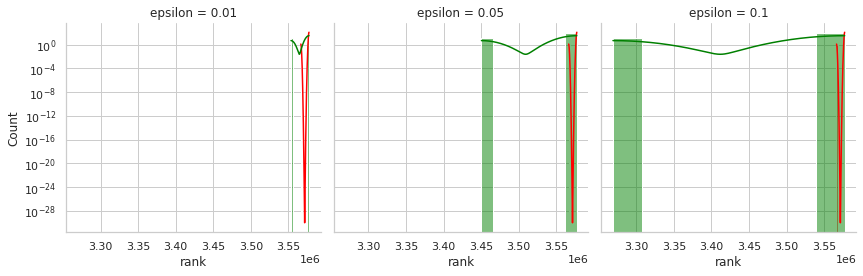

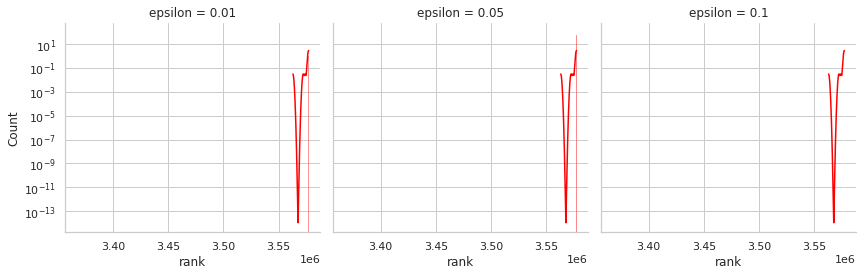

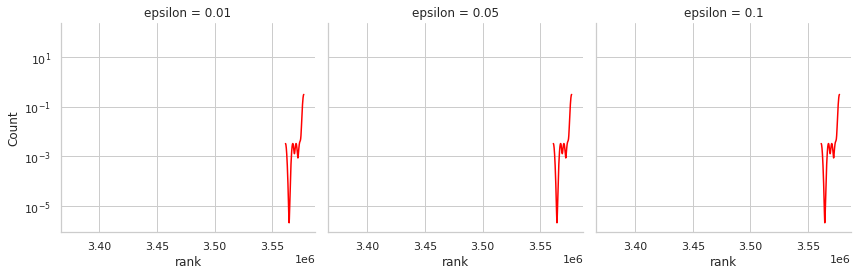

In [139]:
for t in TARGETS:
    g = sns.FacetGrid( df[(df["target"]==t)], col="epsilon", height=4)
    g.map(sns.histplot, "rank_baseline", kde=True, color="red")
    g.map(sns.histplot, "rank", kde=True, color ="green")
    g.set(yscale='log')
    g.savefig(f"../img/histograma_distrib_RANK_t_{t}")

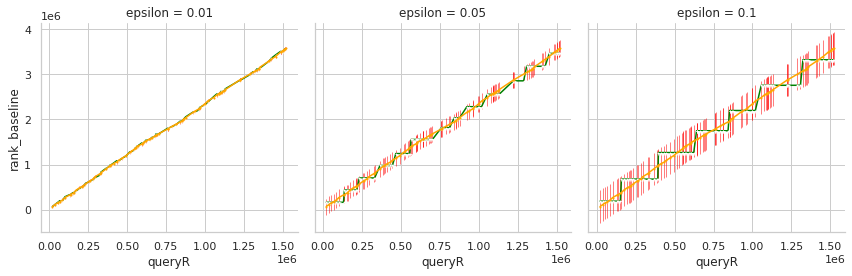

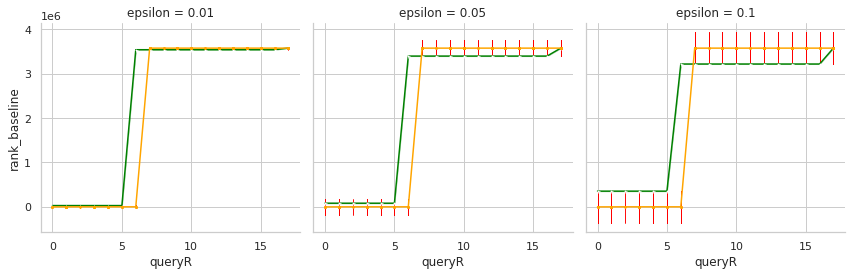

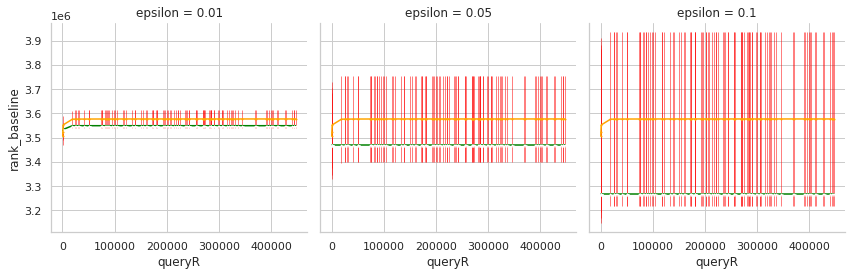

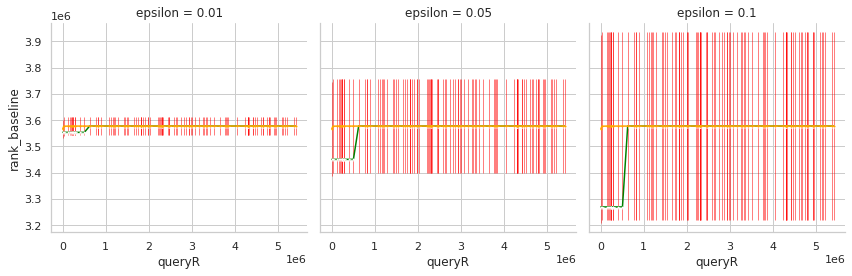

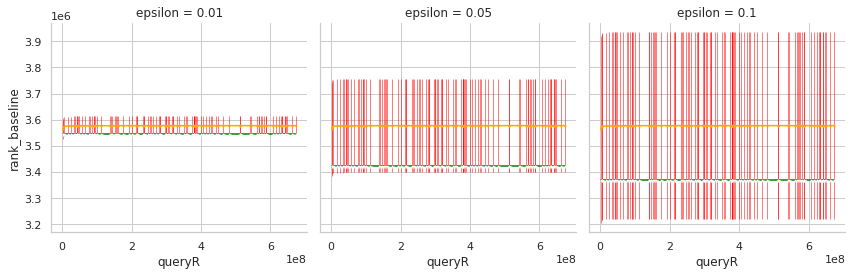

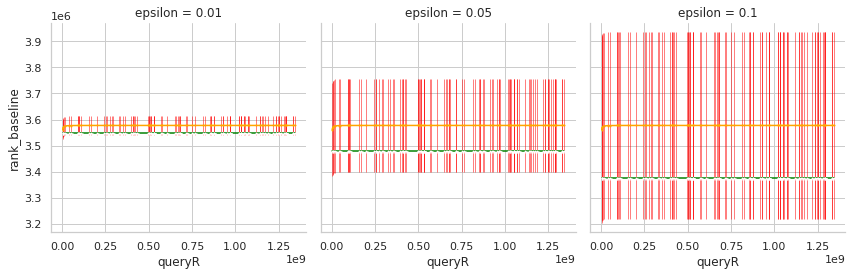

In [140]:
for t in TARGETS:
    g = sns.FacetGrid( df[(df["target"]==t)], col="epsilon", height=4)
    g.map(sns.lineplot, "queryR", "rank", 
          marker="+", color="green", markersize=3)
    g.map(plt.errorbar, "queryR", "rank_baseline", 
          "erro_max", marker=".", ecolor="red", 
          elinewidth=0.5, markersize=2, color="orange")
    g.savefig(f"../img/erroplot_ecdf_RANK_t_{t}")

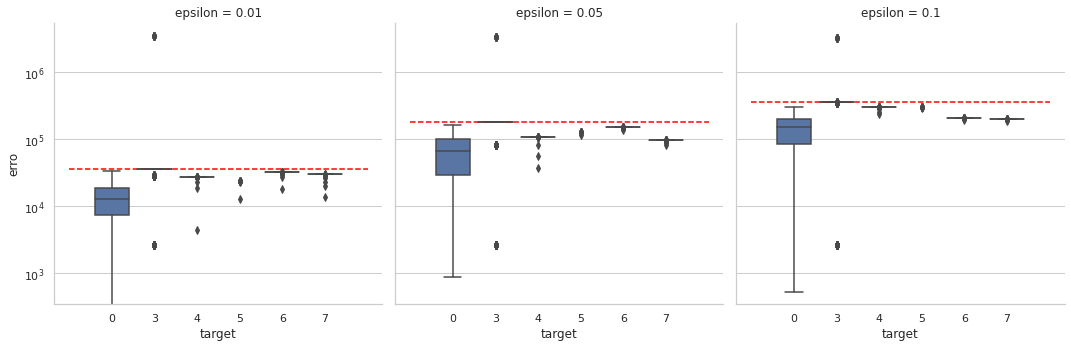

In [142]:
g = sns.catplot(
        data=df, x='target', y="erro",
        col='epsilon', kind='box'
)
#g.set(yscale="log")
t=3577297
for i in range(len(EPS)):
    e=EPS[i]
    g.axes[0][i].hlines(y=t*e,xmin=-1, xmax=len(TARGETS),colors = ["red"], linestyles="dashed")
g.set(yscale="log")
g.savefig(f"../img/boxplot_ERROS")